# Tutorial 9 - Using NumBAT in Jupyter Notebooks

For those who like to work in an interactive fashion,
NumBAT works perfectly well inside a Jupyter notebook. 
This is demonstrated in the file ``jup_09_smf28.ipynb`` using the standard
SMF-28 fibre problem as an example.

On a Linux system, you can open this at the command line with::

  $ jupyter-notebook ``jup_09_smf28.ipynb``

or else load it directly in an already open Jupyter environment.

The notebook demonstrates how to run standard NumBAT routines step by step.
The output is still written to disk, so the notebook includes some simple techniques for 
efficiently displaying mode profiles and spectra inside the notebook. 

### Make some standard inputs.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display
import glob
import numpy as np

In [2]:
sys.path.append("../backend/")  # or whereever you have NumBATApp installed
import numbat
import materials
import structure
import mode_calcs
import integration
import plotting


### Specify the geometry

In [3]:
wl_nm = 1550
domain_x = 5*wl_nm
domain_y = domain_x
inc_a_x = 550
inc_a_y = inc_a_x
inc_shape = 'circular'

num_modes_EM_pump = 20
num_modes_EM_Stokes = num_modes_EM_pump
num_modes_AC = 40
EM_ival_pump = 0
EM_ival_Stokes = 0
AC_ival = 'All'


### Make the structure

In [ ]:
prefix = 'tut_09'
nbapp = numbat.NumBATApp(prefix)

mat_bkg = materials.make_material("Vacuum")
mat_a   = materials.make_material("SiO2_2016_Smith")


wguide = nbapp.make_structure(inc_shape, domain_x, domain_y, inc_a_x, inc_a_y,
                          material_bkg=mat_bkg, material_a=mat_a,
                          lc_bkg=.1, lc_refine_1=10, lc_refine_2=10)

 Calling Gmsh:     initial mesh has: 2077 nodes, 1018 elements. 



### Calculate the EM modes

In [5]:
neff_est = 1.4

sim_EM_pump = wguide.calc_EM_modes(num_modes_EM_pump, wl_nm, n_eff=neff_est)

    initial mesh has: 2077 nodes, 1018 elements. 


 The final EM sim mesh has 2077 nodes, 1018 elements and 2 element types (materials).
 The material index table is: {1: 1, 2: 2} 

 There are 2 active materials:
  Vacuum,              n = 1.00000+0.00000j, mat. index = 1.
  SiO2_2016_Smith,     n = 1.45000+0.00000j, mat. index = 2.


Calculating EM modes:
 Boundary conditions: Dirichlet
 
 -----------------------------------------------
 EM FEM: 
storing em
  Calculating EM mode powers...
using curvilinear elements
   - assembling linear system:
           1018 mesh elements
           2077 mesh nodes
          12097 linear equations (cscmat%n_dof)
         408319 nonzero elements  (cscmat%n_nonz)
          0.279 % sparsity
             10 MB est. working memory 

       cpu time = .15 secs, wall time = .00 secs

  - solving linear system: 

      solving eigensystem
         cpu time = 2.27 secs, wall time = .00 secs

      assembling modes
         cpu time = .08 secs, wall time = 

Find the backward Stokes fields

In [ ]:
sim_EM_Stokes = sim_EM_pump.clone_as_backward_modes()

### Generate EM mode fields

We are now ready to plot EM field profiles, but how many should we ask for?

The $V$-number of this waveguide can be estimated as $V=\frac{2 \pi a}{\lambda} \sqrt{n_c^2-n_{cl}^2}$:

In [ ]:
V=2 *pi/wl_nm * inc_a_x * np.sqrt(np.real(mat_a.refindex_n**2
                                  - mat_bkg.refindex_n**2))
print('V={0:.4f}'.format(V))

V=2.3410


We thus expect only a couple of guided modes and to save time and disk space, only ask for the first few to be generated:

In [7]:
sim_EM_pump.plot_modes(xlim_min=0.2, xlim_max=0.2, ylim_min=0.2, ylim_max=0.2, ivals=range(5))


Plotting 5 em modes in range m=[0,4]:
Structure has raw domain (x,y) =  [-3.87500, 3.87500] x [-3.87500, 3.87500] (μm),
             mapped to (x',y') =  [-3.87500, 3.87500] x [-3.87500, 3.87500] (μm)
  Progress: |xxxxxxxxxxxxxxxxxxxx| 100.0% 


Get a list of the generated files. By sorting the list, the modes will be in order from lowest ($m=0$) to highest.

In [8]:
emfields = glob.glob(prefix+'-fields/EM*.png')
emfields.sort()

In Jupyter, we can display images using the `display(Image(filename=f))` construct.



 tut_09-fields/EM_E_mode_00.png


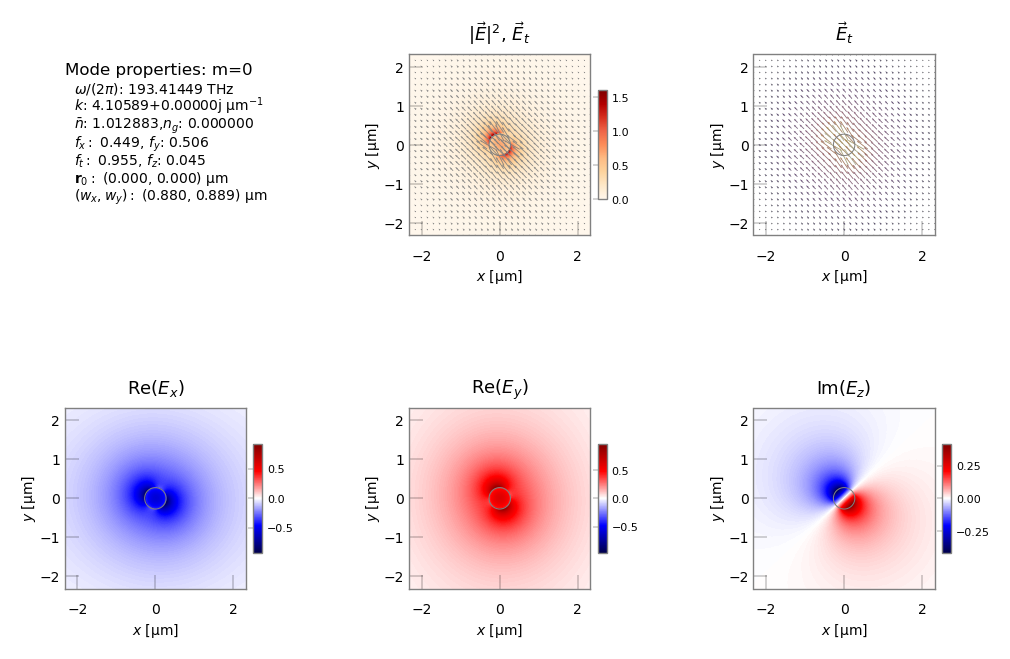



 tut_09-fields/EM_E_mode_01.png


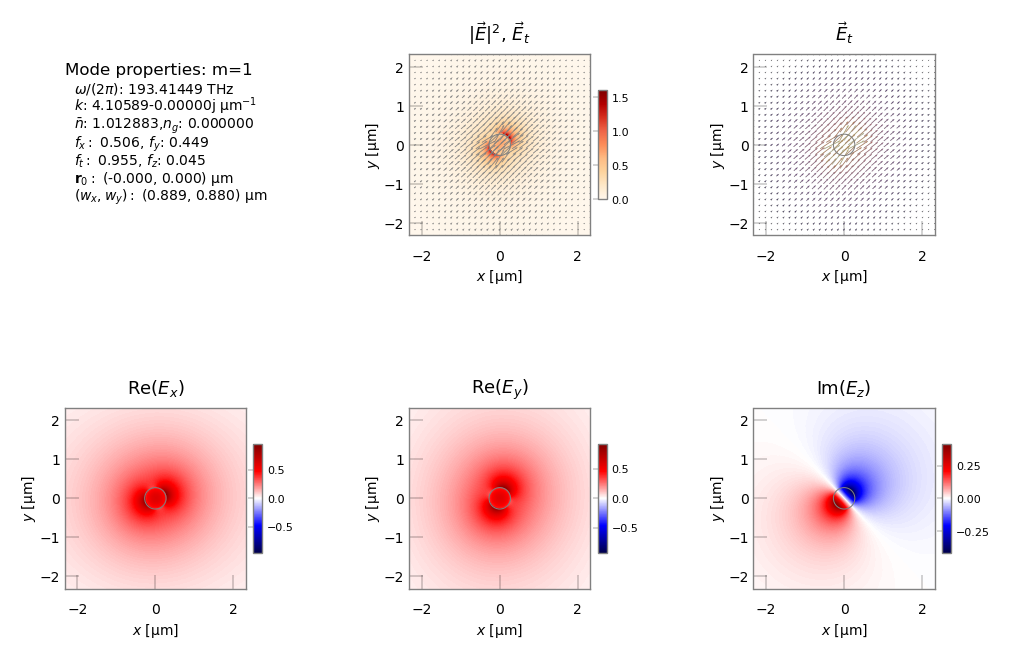



 tut_09-fields/EM_E_mode_02.png


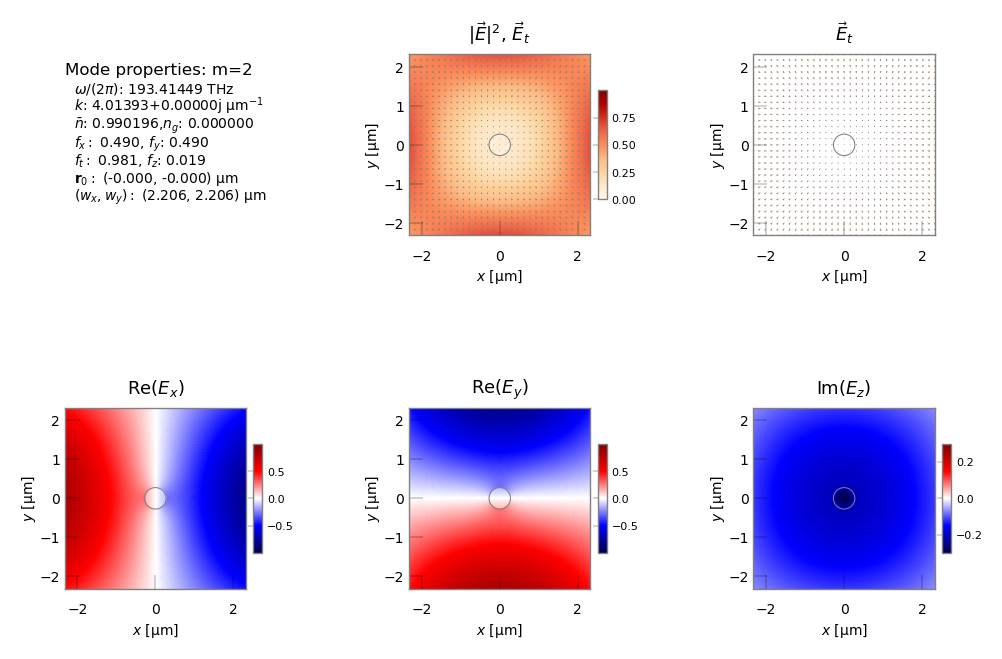

In [9]:
for f in emfields[0:3]:
    print('\n\n',f)
    display(Image(filename=f))

### Calculate the acoustic modes

Now let's turn to the acoustic modes.

For backwards SBS, we set the desired acoustic wavenumber to the difference between the pump and Stokes wavenumbers.
        $\Omega$
    We specify a 'shift' frequency as a starting location of the frequency to look for solutions 

In [15]:
q_AC = np.real(sim_EM_pump.kz_EM(EM_ival_pump) - sim_EM_Stokes.kz_EM(EM_ival_Stokes))

NuShift_Hz = 4e9

sim_AC = wguide.calc_AC_modes(num_modes_AC, q_AC, EM_sim=sim_EM_pump, shift_Hz=NuShift_Hz)



 The final elastic sim mesh has 273 nodes, 124 mesh elements and 1 element types (materials).
 The material index table is: {2: 1} 

 There are 1 active materials:
   SiO2_2016_Smith,     rho = 2.200 g/cc, v_i = [5.9772, 3.7659, 3.7659] km/s.


Calculating elastic modes
doing AC cal
 
 -----------------------------------------------
 AC FEM: 
doing AC mode power
Doing AC mode energy
Acoustic loss calc
   - assembling linear system:
            124 mesh elements
            273 mesh nodes
            819 linear equations
          26541 nonzero elements
          3.957 % sparsity
              1 MB est. working memory 

       cpu time = .00 secs, wall time = .00 secs

  - solving linear system: 

      solving eigensystem
         cpu time = .12 secs, wall time = .00 secs

      assembling modes
         cpu time = .00 secs, wall time = .00 secs
 -----------------------------------------------
 


In [16]:
sim_AC.plot_modes(ivals=range(10))

Plotting 10 acoustic modes in range m=[0,9]:
Structure has raw domain (x,y) =  [-0.27500, 0.27500] x [-0.27500, 0.27500] (μm),
             mapped to (x',y') =  [-0.27500, 0.27500] x [-0.27500, 0.27500] (μm)
  Progress: |xxxxxxxxxxxxxxxxxxxx| 100.0% 


In [17]:
acfields = glob.glob(prefix+'-fields/AC*.png')
acfields.sort()




 tut_09-fields/AC_mode_00.png


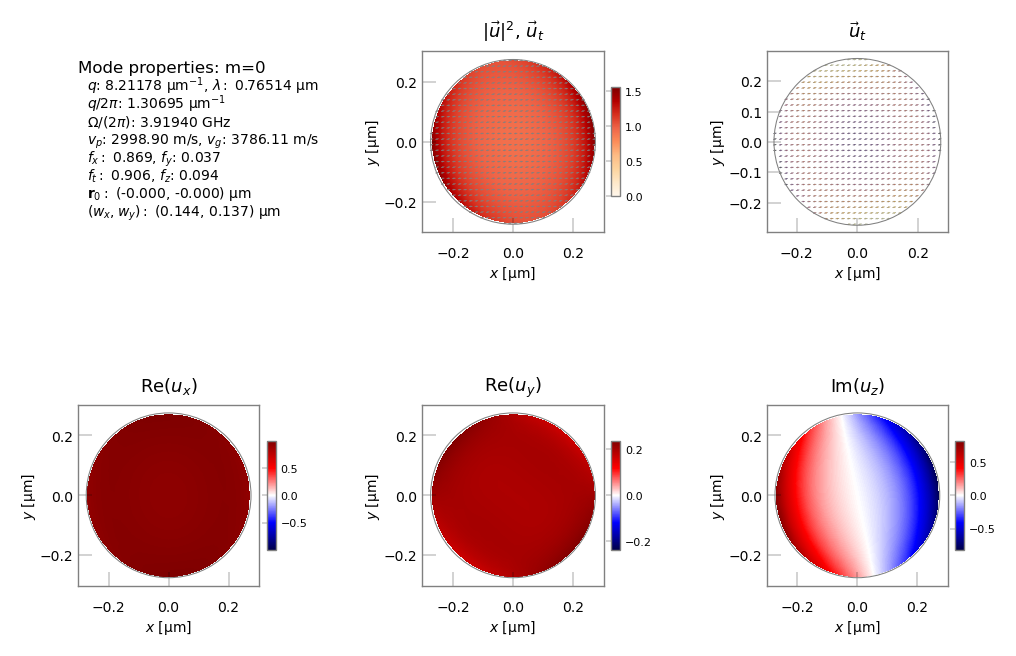



 tut_09-fields/AC_mode_01.png


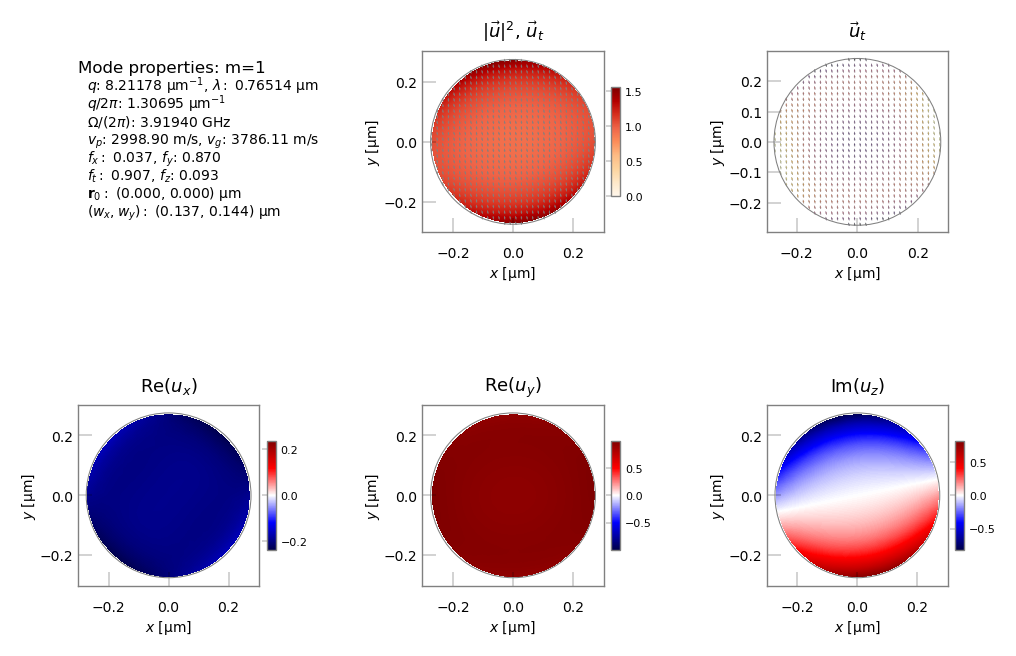



 tut_09-fields/AC_mode_02.png


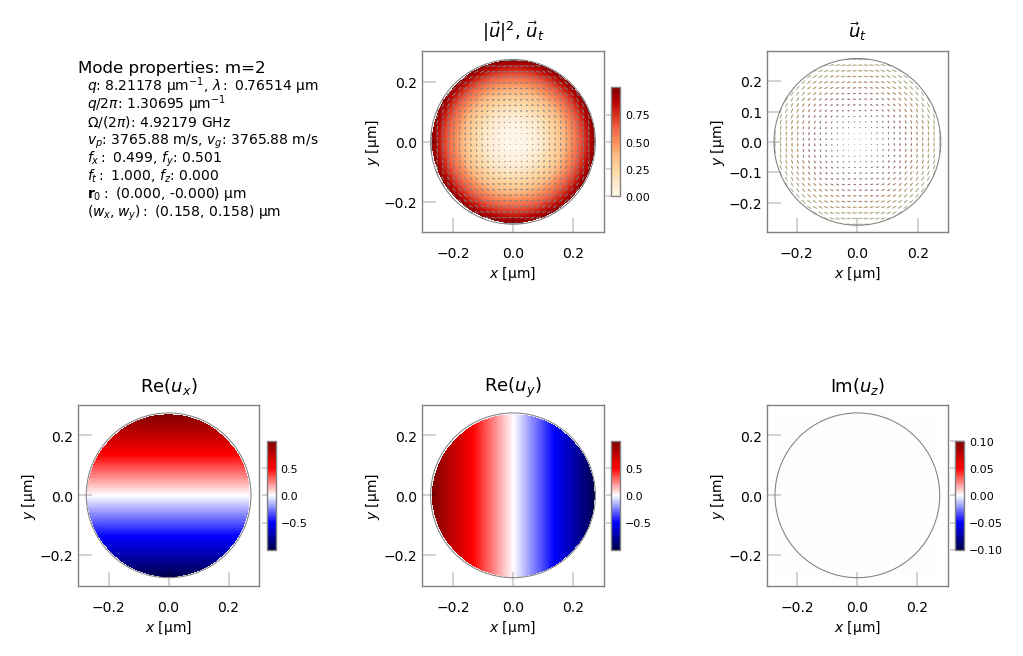



 tut_09-fields/AC_mode_03.png


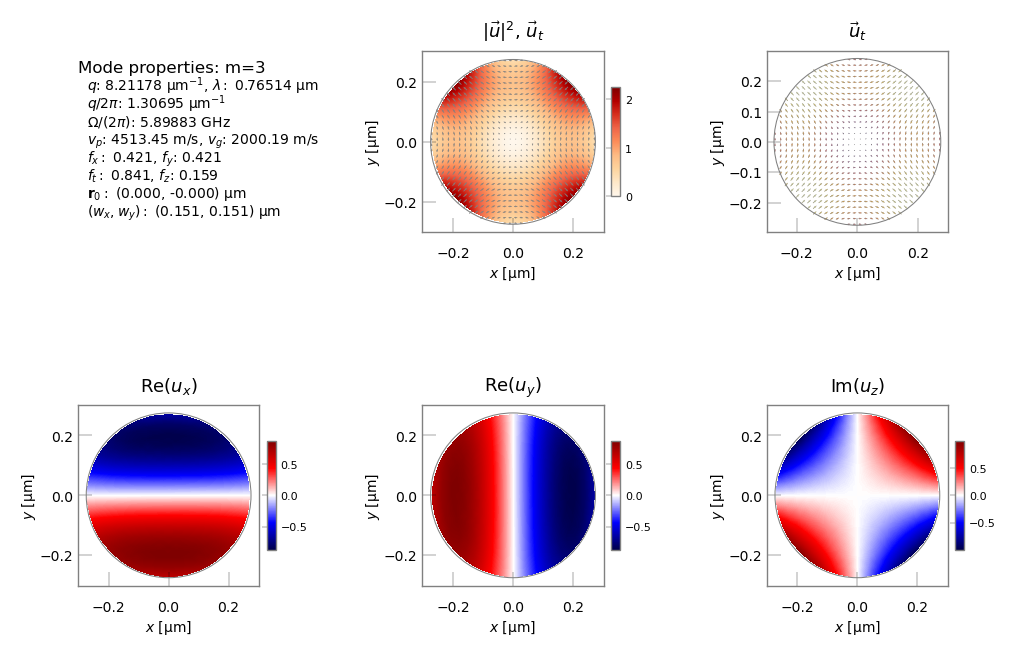



 tut_09-fields/AC_mode_04.png


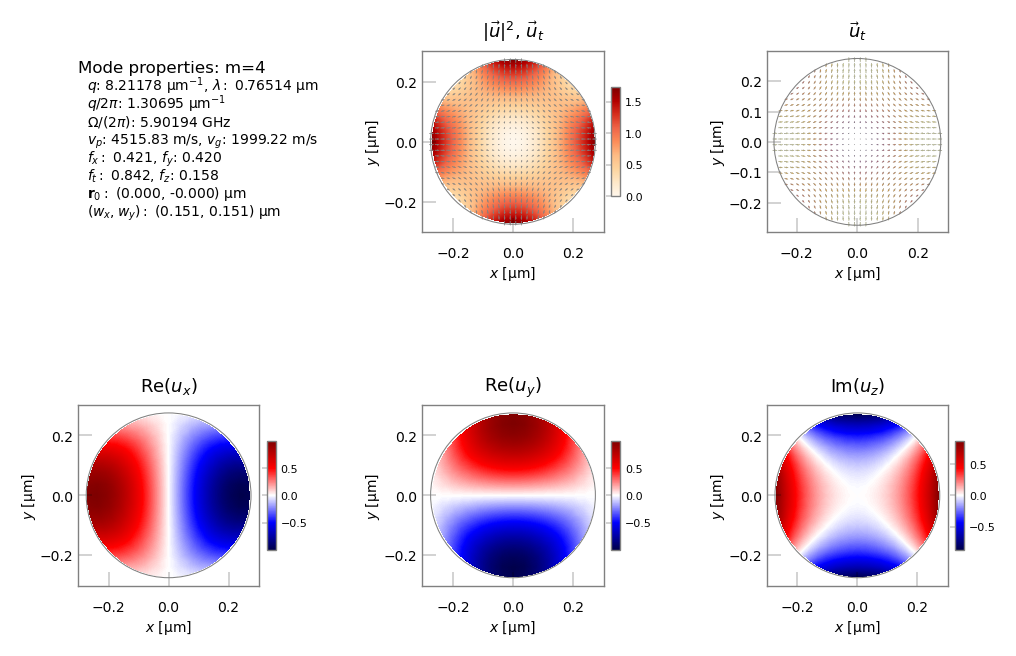



 tut_09-fields/AC_mode_05.png


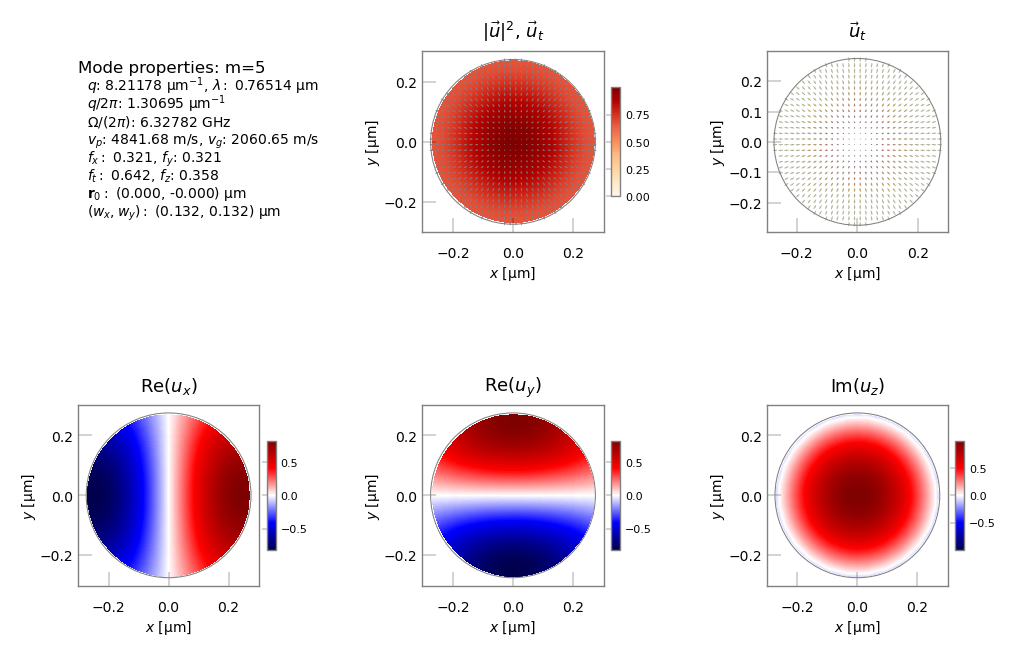

In [18]:
for f in acfields[0:6]:
    print('\n\n',f)
    display(Image(filename=f))